In [1]:

import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import PIL
import torch
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms

from torch import nn, optim
from tqdm import tqdm



SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

dataset = load_dataset('lambdalabs/naruto-blip-captions')




Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import CLIPTokenizer
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from datasets import load_dataset
import random
from PIL import Image
import numpy as np

SEED = 42
HALF_RATIO = 1
BATCH_SIZE = 1  
EPOCHS = 10
IMAGE_SIZE = (64, 64)  

random.seed(SEED)
torch.manual_seed(SEED)

dataset_split = dataset['train'].train_test_split(test_size=0.25, seed=SEED)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']

def convert_dataset_to_list(dataset_split):
    return [{'image': item['image'], 'text': item['text']} for item in dataset_split]

train_dataset_list = convert_dataset_to_list(train_dataset)
test_dataset_list = convert_dataset_to_list(test_dataset)


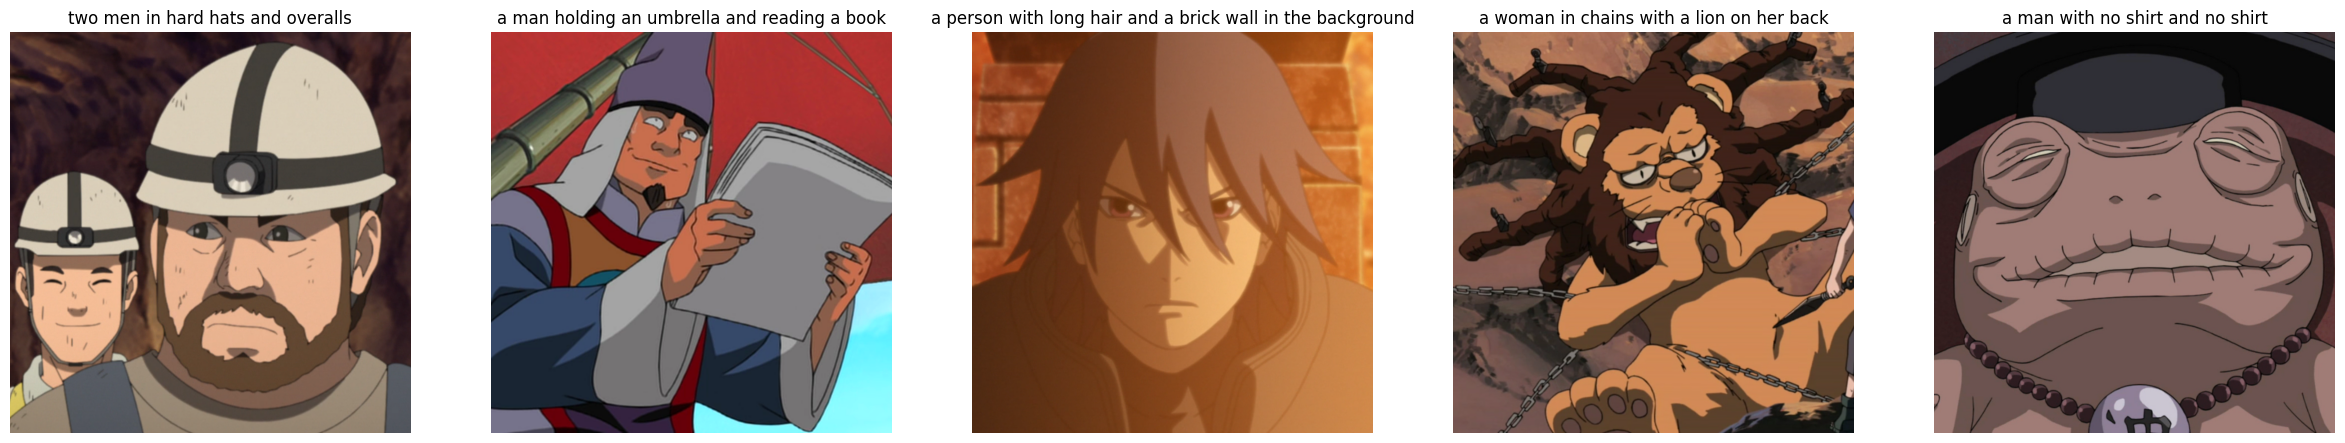

In [3]:

def visualize_samples(samples, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(30, 30))
    for i in range(num_samples):
        image = samples[i]['image']
        axs[i].imshow(image)
        axs[i].set_title(samples[i]['text'])
        axs[i].axis('off')
    plt.show()

visualize_samples(train_dataset_list, 5)

In [4]:

train_dataset_list = random.sample(train_dataset_list, int(len(train_dataset_list) * HALF_RATIO))
test_dataset_list = random.sample(test_dataset_list, int(len(test_dataset_list) * HALF_RATIO))

tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

In [5]:

class NarutoDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer, target_size):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.target_size = target_size
        self.transform = transforms.Compose([
            transforms.Resize(self.target_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(self.target_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.dataset)

    def preprocess_image(self, image):
        image = self.transform(image)
        return image

    def __getitem__(self, idx):
        data = self.dataset[idx]
        image = data['image'].convert('RGB')
        image = self.preprocess_image(image)
        text = data['text']
        input_ids = self.tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=77)['input_ids'].squeeze()
        return {'image': image, 'input_ids': input_ids}

train_dataset = NarutoDataset(train_dataset_list, tokenizer, IMAGE_SIZE)
test_dataset = NarutoDataset(test_dataset_list, tokenizer, IMAGE_SIZE)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

def clear_gpu_memory():
    torch.cuda.empty_cache()

def add_noise_channel(images):
    noise = torch.randn_like(images[:, :1, :, :])
    return torch.cat([images, noise], dim=1)


In [6]:
!pip install peft diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 2.7 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.6 MB/s eta 0:00:0000:0100:01


In [7]:

from peft import LoraConfig, get_peft_model
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

unet = pipe.unet

def list_unet_submodules(model):
    for name, _ in model.named_modules():
        print(name)

print("Available submodules in UNet:")
list_unet_submodules(unet)



2024-05-19 12:01:21.911578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 12:01:21.911692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 12:01:22.029916: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Available submodules in UNet:

conv_in
time_proj
time_embedding
time_embedding.linear_1
time_embedding.act
time_embedding.linear_2
down_blocks
down_blocks.0
down_blocks.0.attentions
down_blocks.0.attentions.0
down_blocks.0.attentions.0.norm
down_blocks.0.attentions.0.proj_in
down_blocks.0.attentions.0.transformer_blocks
down_blocks.0.attentions.0.transformer_blocks.0
down_blocks.0.attentions.0.transformer_blocks.0.norm1
down_blocks.0.attentions.0.transformer_blocks.0.attn1
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.1
down_blocks.0.attentions.0.transformer_blocks.0.norm2
down_blocks.0.attentions.0.transformer_blocks.0.attn2
down_blocks.0.attentions.0.transformer_blocks.0.at

In [8]:

from peft import LoraConfig, get_peft_model
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

unet = pipe.unet
base_lora_config = {
    "lora_alpha": 16,
    "lora_dropout": 0.05,
    "target_modules": [
        # Down Blocks
        "down_blocks.0.attentions.0.proj_in",
        "down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q",
        "down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k",
        "down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v",
        "down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0",
        "down_blocks.1.attentions.0.proj_in",
        "down_blocks.1.attentions.0.transformer_blocks.0.attn1.to_q",
        "down_blocks.1.attentions.0.transformer_blocks.0.attn1.to_k",
        "down_blocks.1.attentions.0.transformer_blocks.0.attn1.to_v",
        "down_blocks.1.attentions.0.transformer_blocks.0.attn1.to_out.0",
        "down_blocks.2.attentions.0.proj_in",
        "down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_q",
        "down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_k",
        "down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_v",
        "down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_out.0",

        # Middle Block
        "mid_block.attentions.0.proj_in",
        "mid_block.attentions.0.transformer_blocks.0.attn1.to_q",
        "mid_block.attentions.0.transformer_blocks.0.attn1.to_k",
        "mid_block.attentions.0.transformer_blocks.0.attn1.to_v",
        "mid_block.attentions.0.transformer_blocks.0.attn1.to_out.0",

        # Up Blocks
        "up_blocks.0.attentions.0.proj_in",
        "up_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q",
        "up_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k",
        "up_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v",
        "up_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0",
        "up_blocks.1.attentions.0.proj_in",
        "up_blocks.1.attentions.0.transformer_blocks.0.attn1.to_q",
        "up_blocks.1.attentions.0.transformer_blocks.0.attn1.to_k",
        "up_blocks.1.attentions.0.transformer_blocks.0.attn1.to_v",
        "up_blocks.1.attentions.0.transformer_blocks.0.attn1.to_out.0",
        "up_blocks.2.attentions.0.proj_in",
        "up_blocks.2.attentions.0.transformer_blocks.0.attn1.to_q",
        "up_blocks.2.attentions.0.transformer_blocks.0.attn1.to_k",
        "up_blocks.2.attentions.0.transformer_blocks.0.attn1.to_v",
        "up_blocks.2.attentions.0.transformer_blocks.0.attn1.to_out.0"
    ],
    "task_type": "UNET"
}



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [9]:

lora_config = LoraConfig(
    r=16,  
    lora_alpha=base_lora_config["lora_alpha"],
    lora_dropout=base_lora_config["lora_dropout"],
    target_modules=base_lora_config["target_modules"],
    task_type=base_lora_config["task_type"]
)


In [10]:

unet = pipe.unet

unet_with_lora = get_peft_model(unet, lora_config)

pipe.unet = unet_with_lora

torch.cuda.empty_cache()

print("LoRA model applied to UNet successfully.")


LoRA model applied to UNet successfully.


In [11]:

def print_trainable_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Trainable parameters (%): {100 * trainable_params / total_params:.2f}%")

print_trainable_parameters(unet_with_lora)

# Clear GPU memory
torch.cuda.empty_cache()

Total parameters: 860391364
Trainable parameters: 870400
Trainable parameters (%): 0.10%


In [12]:

print(lora_config)


LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='UNET', inference_mode=False, r=16, target_modules={'down_blocks.0.attentions.0.proj_in', 'up_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k', 'up_blocks.2.attentions.0.transformer_blocks.0.attn1.to_q', 'mid_block.attentions.0.proj_in', 'down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_k', 'mid_block.attentions.0.transformer_blocks.0.attn1.to_out.0', 'down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_v', 'down_blocks.1.attentions.0.proj_in', 'down_blocks.1.attentions.0.transformer_blocks.0.attn1.to_out.0', 'down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_q', 'up_blocks.1.attentions.0.transformer_blocks.0.attn1.to_v', 'up_blocks.2.attentions.0.proj_in', 'down_blocks.1.attentions.0.transformer_blocks.0.attn1.to_k', 'down_blocks.2.attentions.0.proj_in', 'down_blocks.1.attentions.0.transformer_blocks.0.attn1.to_q', 'up_blocks.0.attentions.0.

In [22]:

from transformers import CLIPTextModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 5
learning_rate = 1e-3

criterion = nn.MSELoss()
optimizer = optim.AdamW(unet_with_lora.parameters(), lr=learning_rate)

from transformers import CLIPTextModel

text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32').to(device)

In [23]:

def add_noise_channel(images):
    noise = torch.randn_like(images[:, :1, :, :])
    return torch.cat([images, noise], dim=1)

def clear_gpu_memory():
    torch.cuda.empty_cache()

In [24]:

def add_noise_channel(images):
    noise = torch.randn_like(images[:, :1, :, :])
    return torch.cat([images, noise], dim=1)

def clear_gpu_memory():
    torch.cuda.empty_cache()

def train_model(unet_with_lora, train_dataloader, num_epochs, criterion, text_encoder, text_proj):
    unet_with_lora.to(device)
    unet_with_lora.train()
    optimizer = optim.AdamW(unet_with_lora.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = batch['image'].to(device, dtype=torch.float32)
            input_ids = batch['input_ids'].to(device)

            optimizer.zero_grad()
            encoder_hidden_states = text_encoder(input_ids).last_hidden_state
            encoder_hidden_states = text_proj(encoder_hidden_states)

            timestep = torch.randint(0, 1000, (images.shape[0],), device=device).long()
            images = add_noise_channel(images)

            outputs = unet_with_lora(images, timestep=timestep, encoder_hidden_states=encoder_hidden_states)
            loss = criterion(outputs.sample, images)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_dataloader):.4f}")
        clear_gpu_memory()


In [25]:

class TextProjection(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TextProjection, self).__init__()
        self.proj = nn.Linear(input_dim, output_dim)

    def forward(self, hidden_states):
        return self.proj(hidden_states)

text_proj = TextProjection(512, 768).to(device)

In [33]:

import matplotlib.pyplot as plt
import torch

def visualize_samples(unet_with_lora, text_encoder, text_proj, dataset, num_samples=20, sampling_steps=50):
    unet_with_lora.eval()
    fig, axs = plt.subplots(4, 5, figsize=(20, 16))  
    for i in range(num_samples):
        batch = dataset[i]
        text = batch['text']
        input_ids = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=77)['input_ids'].to(device)

        encoder_hidden_states = text_encoder(input_ids).last_hidden_state
        encoder_hidden_states = text_proj(encoder_hidden_states)

        noise = torch.randn(1, 4, 64, 64).to(device)

        for step in range(sampling_steps):
            timestep = torch.tensor([sampling_steps - step - 1], device=device).long()
            with torch.no_grad():
                noise = unet_with_lora(noise, timestep=timestep, encoder_hidden_states=encoder_hidden_states).sample

        sample = (noise.squeeze().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        axs[i // 5, i % 5].imshow(sample)
        axs[i // 5, i % 5].set_title(text)
        axs[i // 5, i % 5].axis("off")

    plt.tight_layout()
    plt.show()


ranks = [32,64,128]
results = {}


Epoch 1/5: 100%|██████████| 915/915 [12:04<00:00,  1.26it/s]


Epoch 1, Loss: 0.0176


Epoch 2/5: 100%|██████████| 915/915 [12:05<00:00,  1.26it/s]


Epoch 2, Loss: 0.0046


Epoch 3/5: 100%|██████████| 915/915 [12:05<00:00,  1.26it/s]


Epoch 3, Loss: 0.0038


Epoch 4/5: 100%|██████████| 915/915 [12:05<00:00,  1.26it/s]


Epoch 4, Loss: 0.0031


Epoch 5/5: 100%|██████████| 915/915 [12:05<00:00,  1.26it/s]


Epoch 5, Loss: 0.0024


Epoch 1/5: 100%|██████████| 915/915 [12:07<00:00,  1.26it/s]


Epoch 1, Loss: 0.0201


Epoch 2/5: 100%|██████████| 915/915 [12:07<00:00,  1.26it/s]


Epoch 2, Loss: 0.0047


Epoch 3/5: 100%|██████████| 915/915 [12:07<00:00,  1.26it/s]


Epoch 3, Loss: 0.0038


Epoch 4/5: 100%|██████████| 915/915 [12:07<00:00,  1.26it/s]


Epoch 4, Loss: 0.0030


Epoch 5/5: 100%|██████████| 915/915 [12:07<00:00,  1.26it/s]


Epoch 5, Loss: 0.0024


Epoch 1/5: 100%|██████████| 915/915 [12:10<00:00,  1.25it/s]


Epoch 1, Loss: 0.0166


Epoch 2/5: 100%|██████████| 915/915 [12:10<00:00,  1.25it/s]


Epoch 2, Loss: 0.0044


Epoch 3/5: 100%|██████████| 915/915 [12:11<00:00,  1.25it/s]


Epoch 3, Loss: 0.0041


Epoch 4/5: 100%|██████████| 915/915 [12:11<00:00,  1.25it/s]


Epoch 4, Loss: 0.0030


Epoch 5/5: 100%|██████████| 915/915 [12:10<00:00,  1.25it/s]


Epoch 5, Loss: 0.0023
Results for LoRA rank 32:


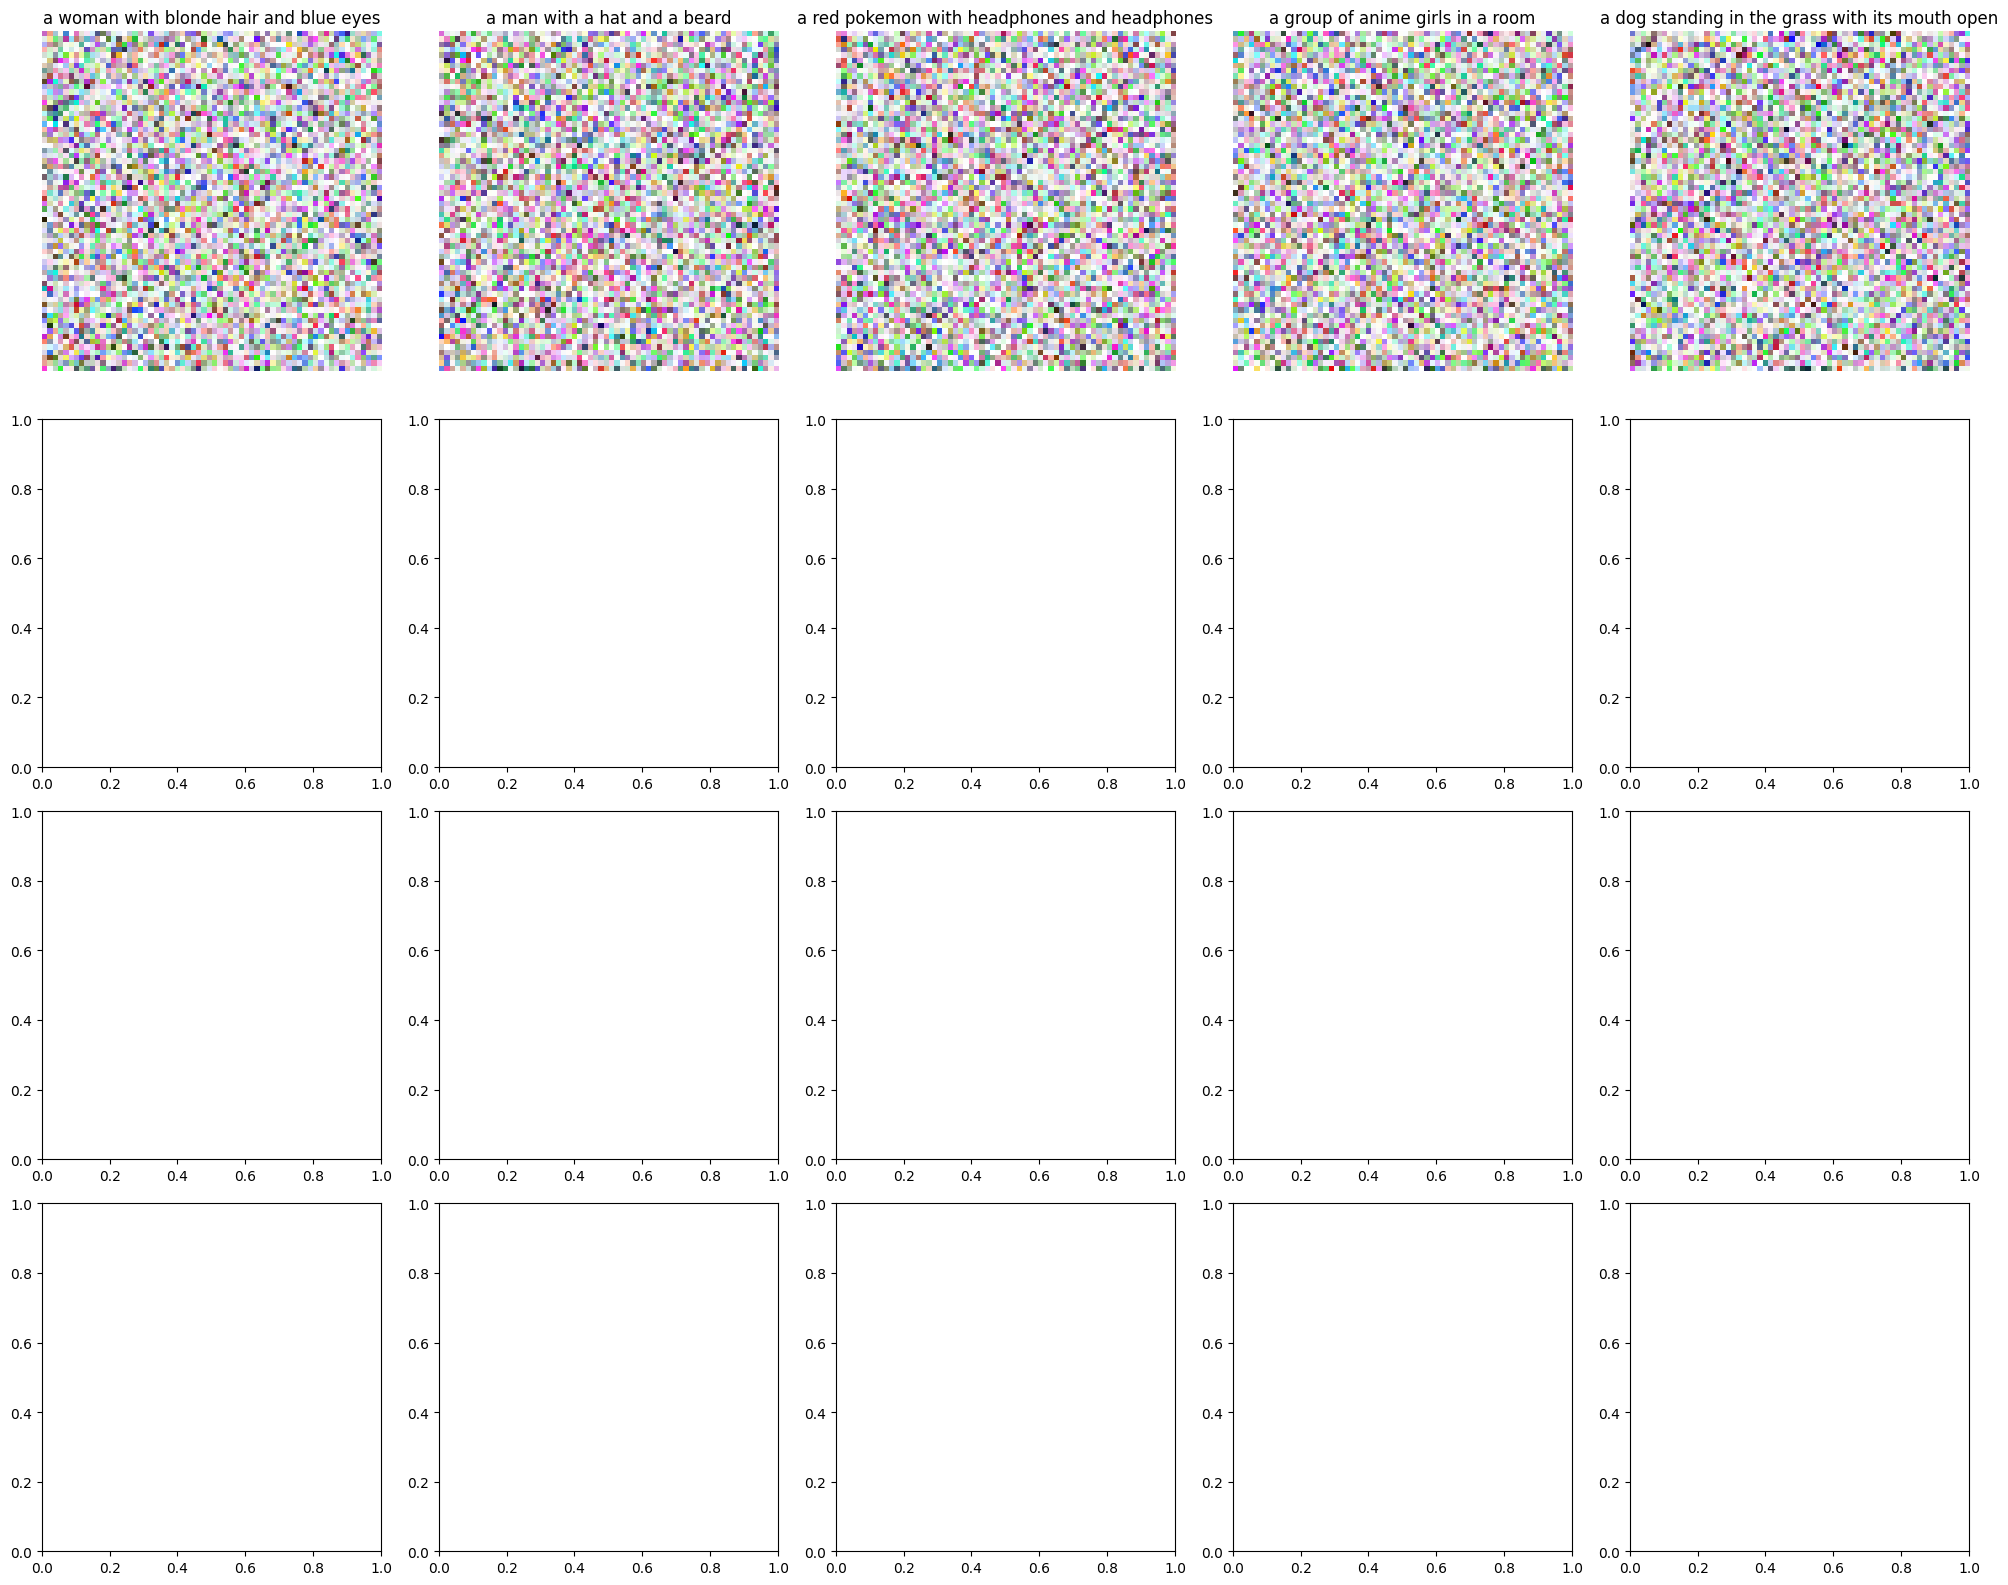

Results for LoRA rank 64:


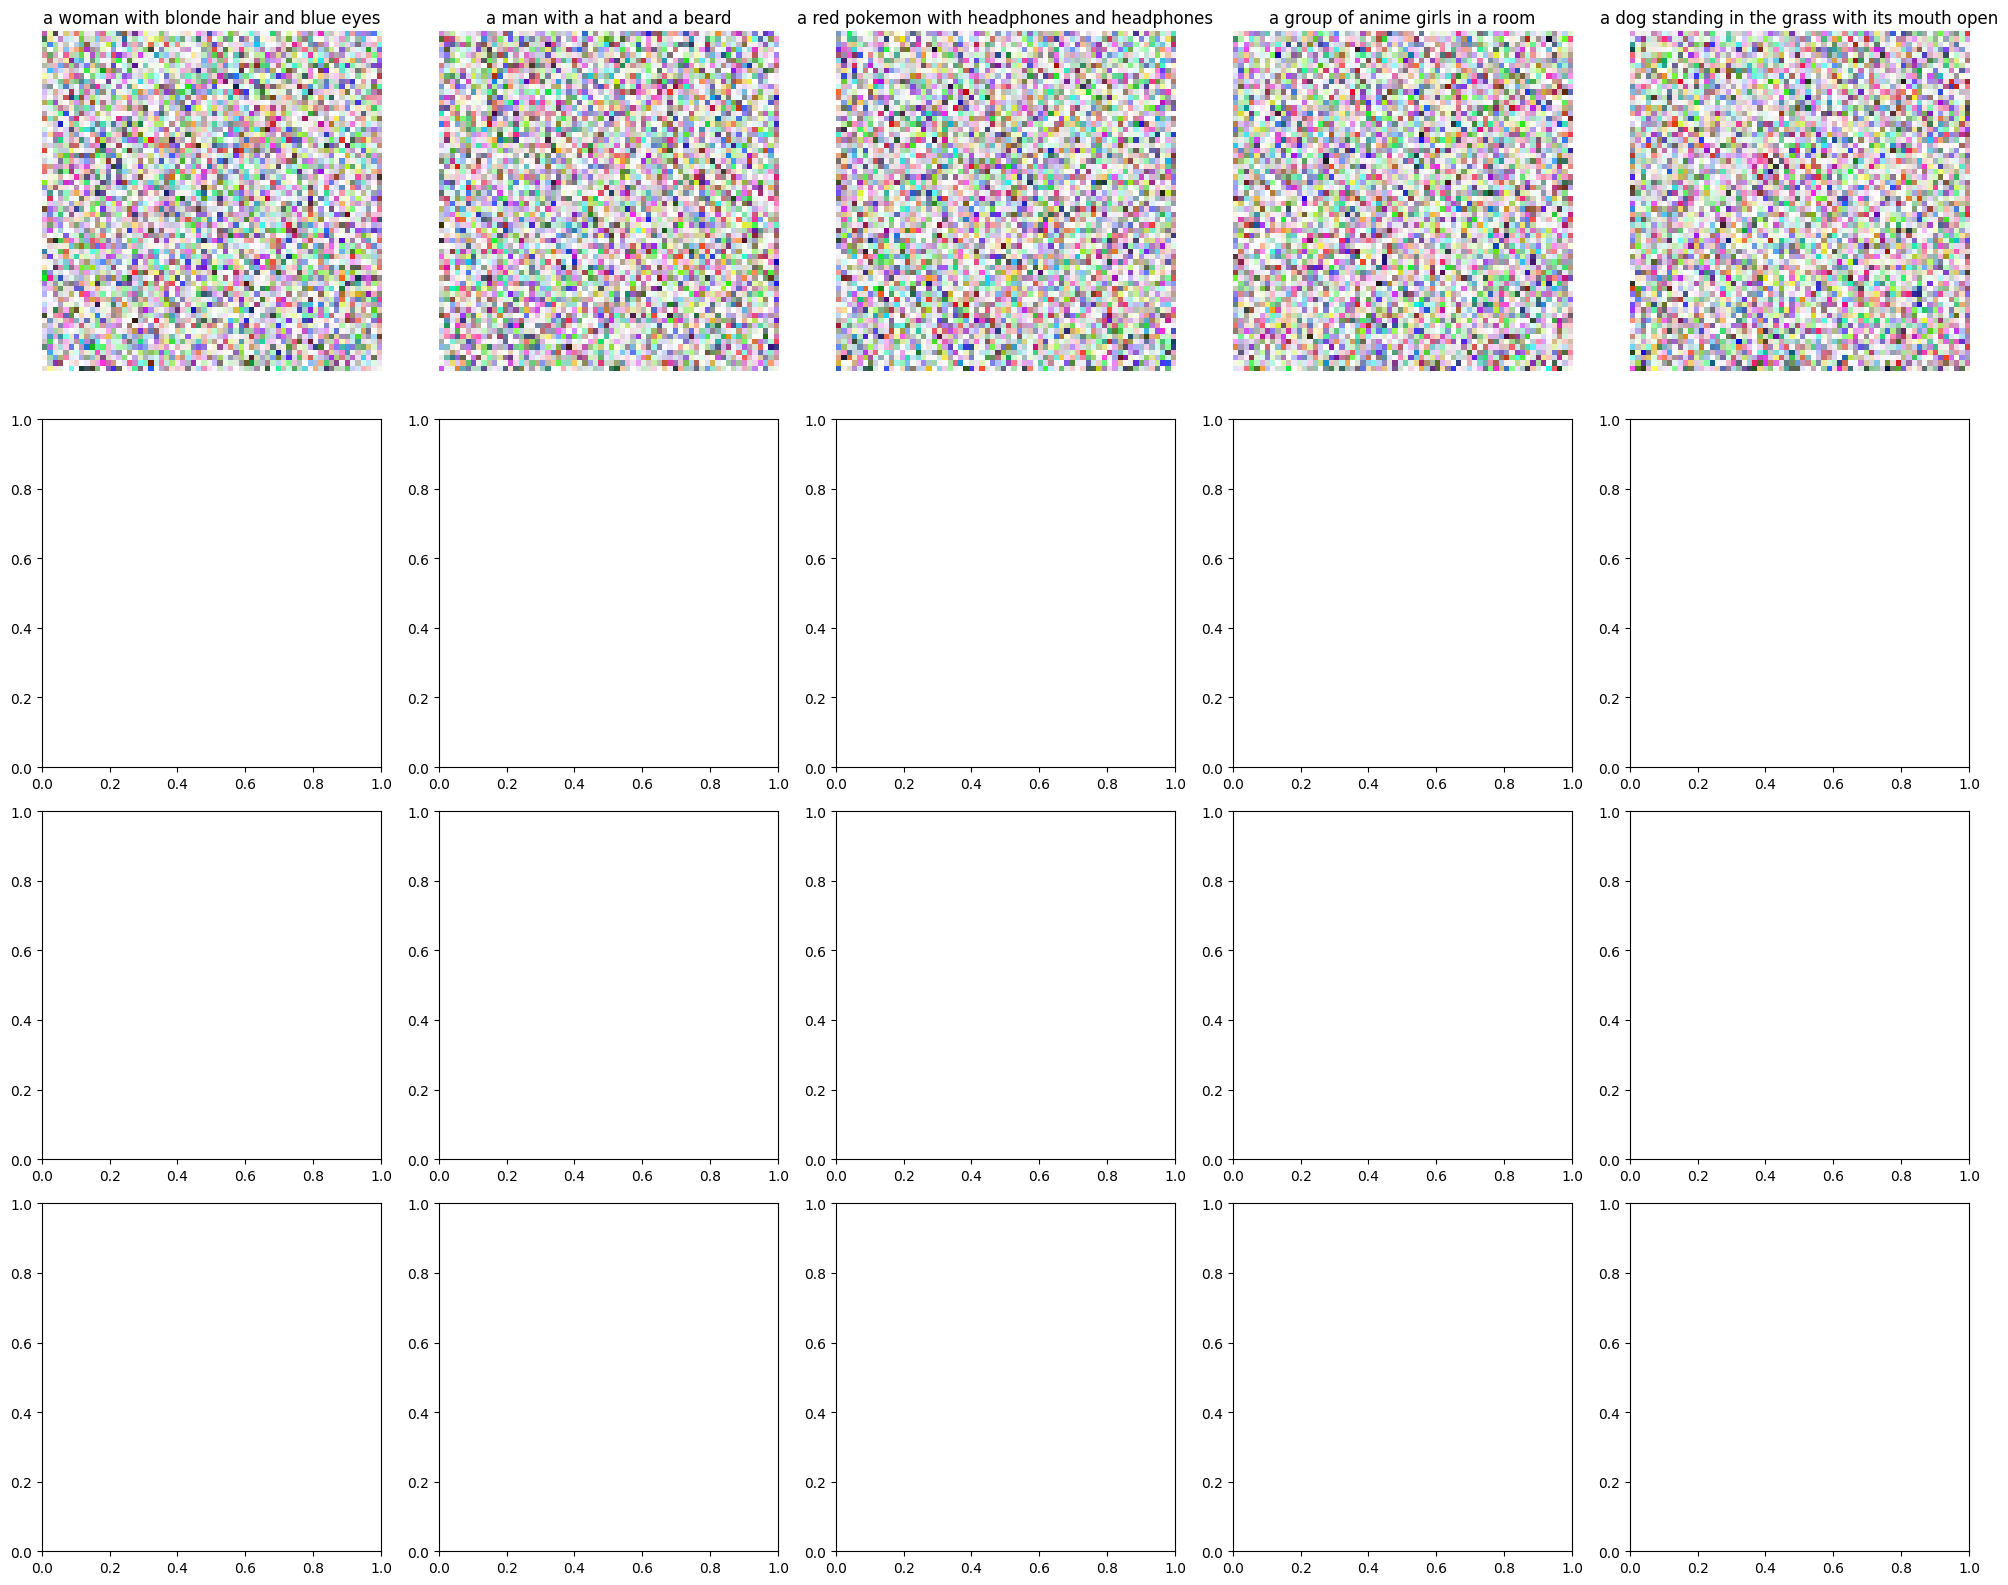

Results for LoRA rank 128:


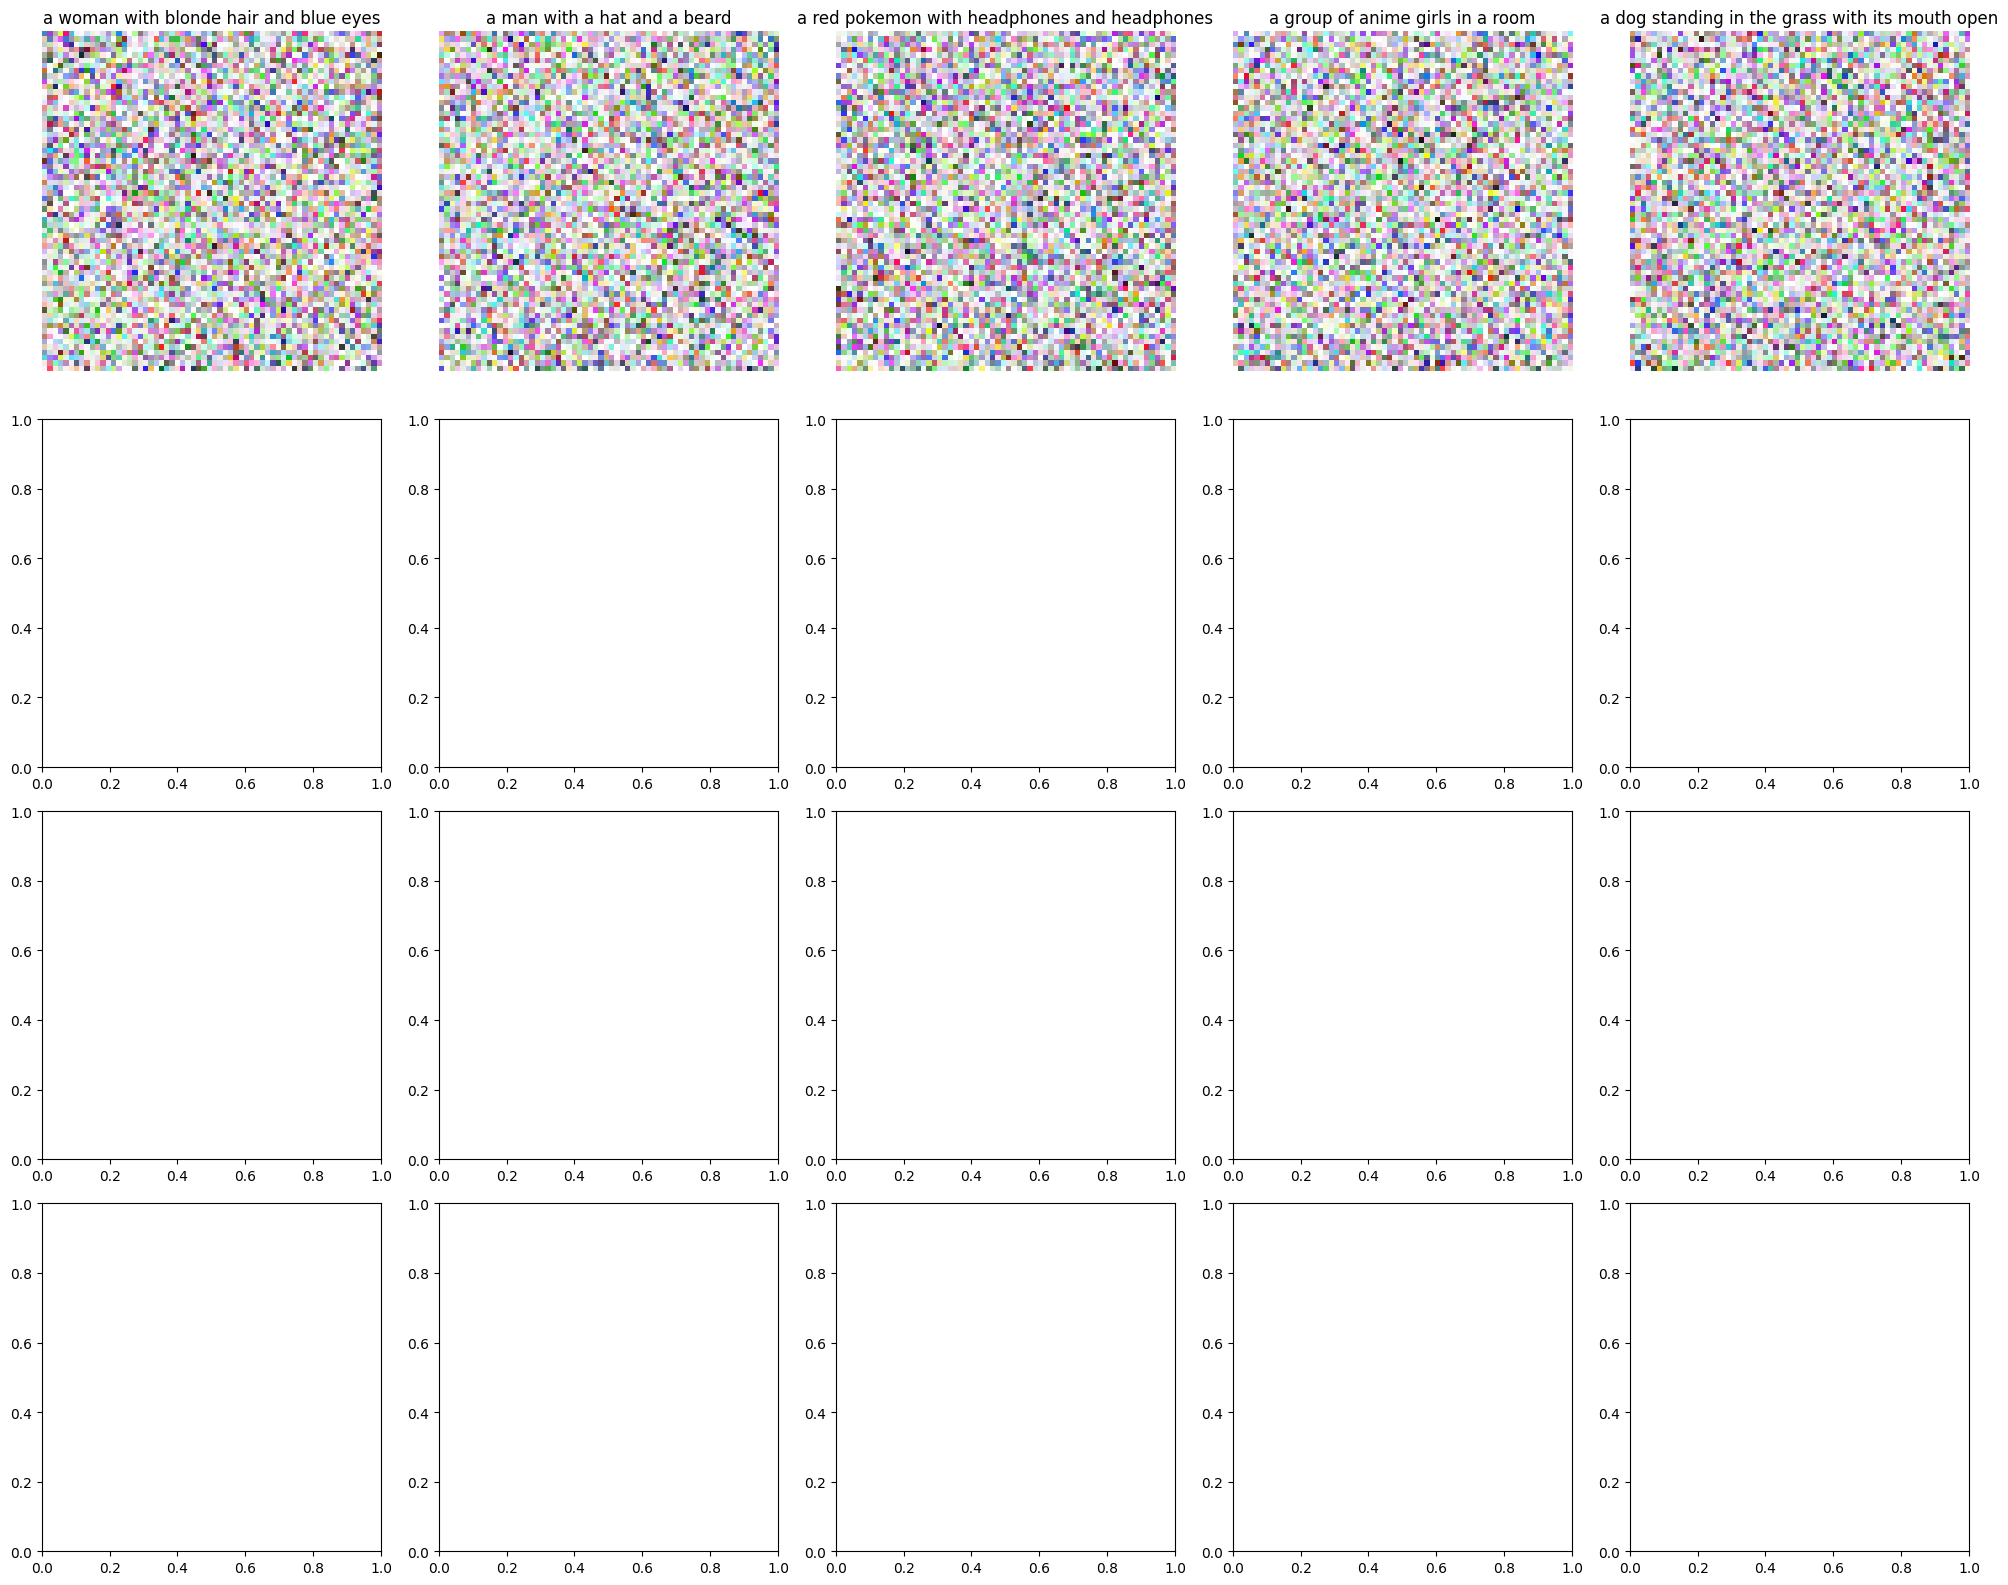

In [36]:



for rank in ranks:
    lora_config = LoraConfig(
        r=rank,
        lora_alpha=base_lora_config["lora_alpha"],
        lora_dropout=base_lora_config["lora_dropout"],
        target_modules=base_lora_config["target_modules"],
        task_type=base_lora_config["task_type"]
    )
    
    unet_with_lora = get_peft_model(pipe.unet, lora_config)
    train_model(unet_with_lora, train_dataloader, num_epochs, criterion, text_encoder, text_proj)
    results[rank] = unet_with_lora

for rank, model in results.items():
    print(f"Results for LoRA rank {rank}:")
    visualize_samples(model, text_encoder, text_proj, test_dataset_list, num_samples=5)


Results for LoRA rank 32:


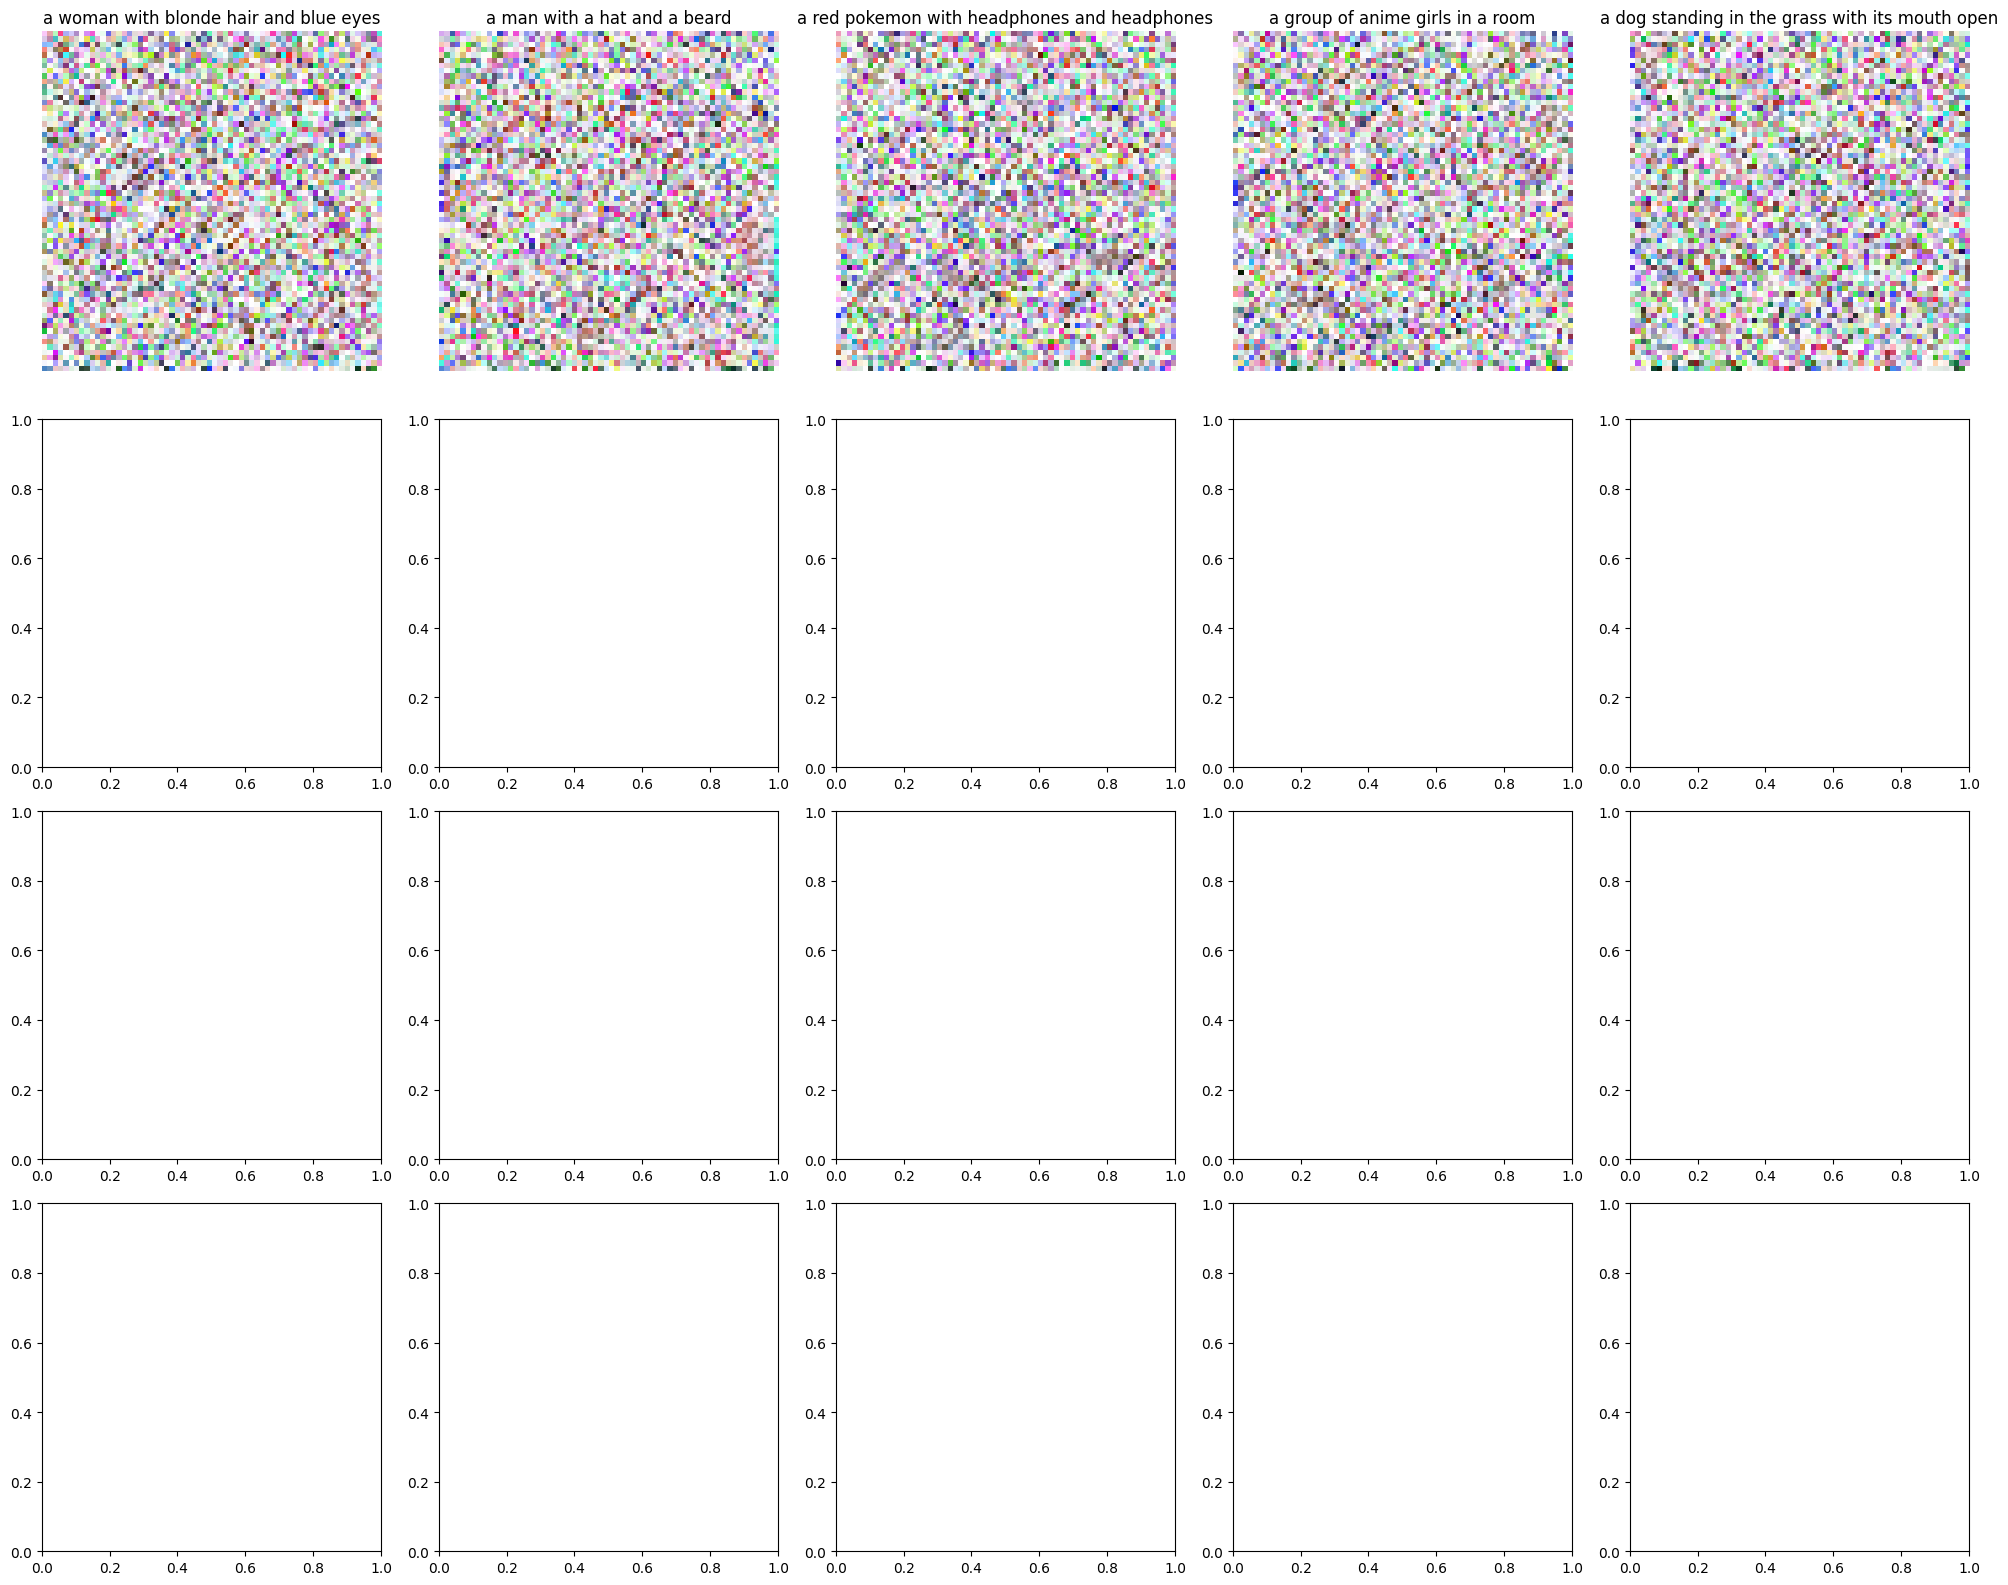

Results for LoRA rank 64:


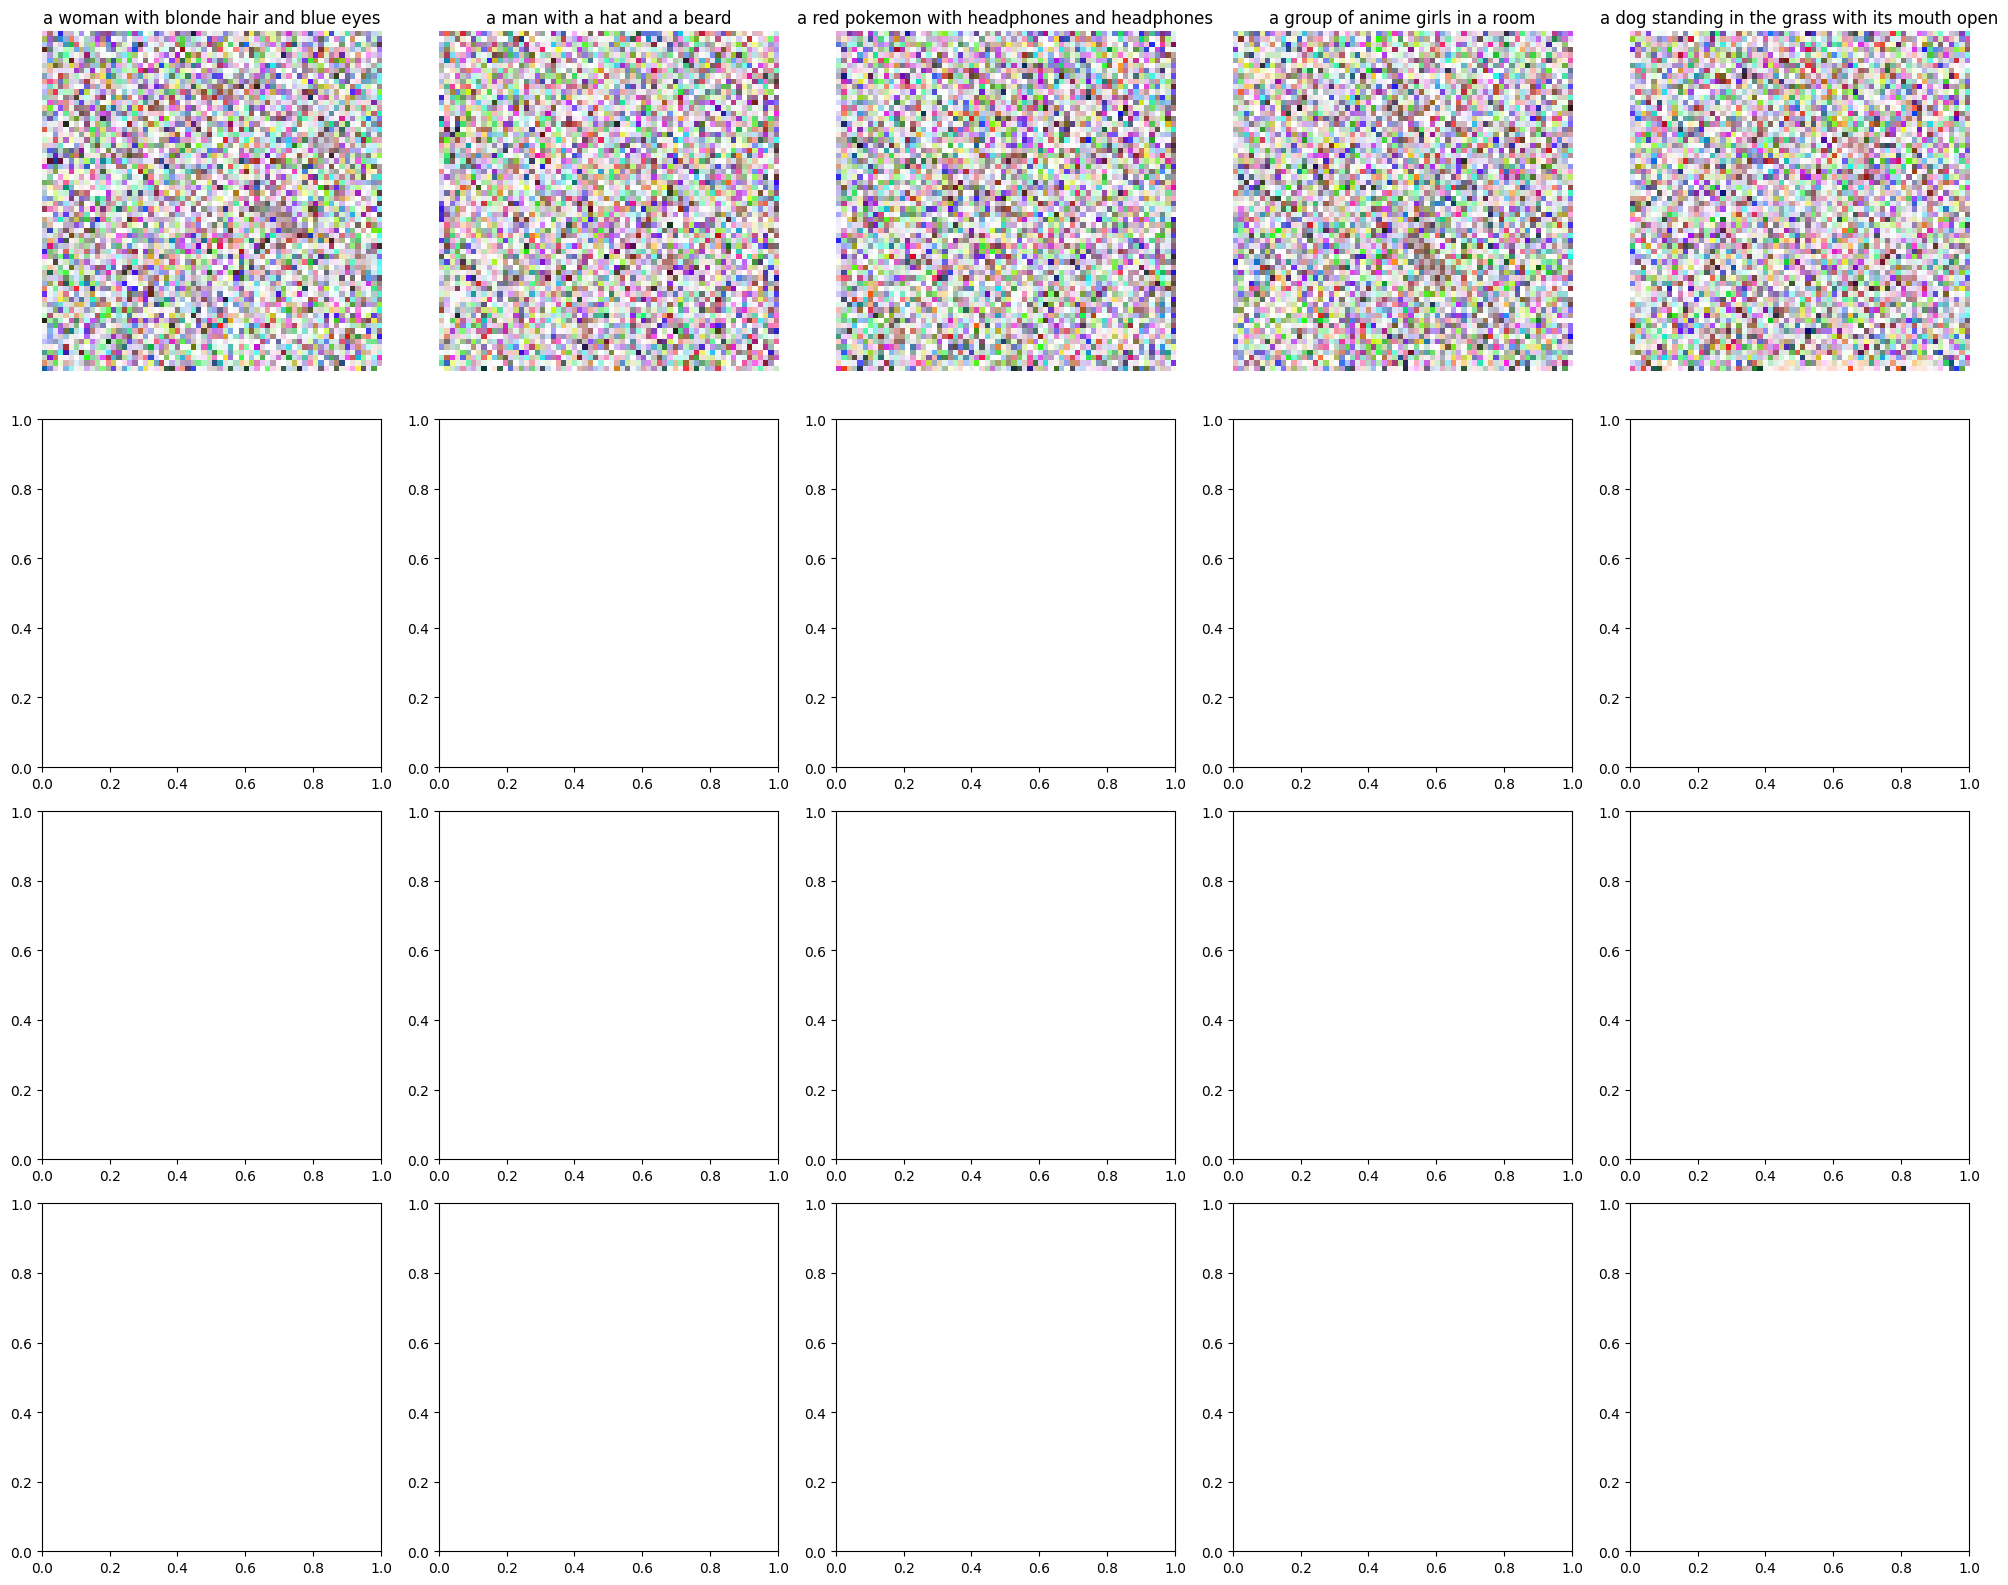

Results for LoRA rank 128:


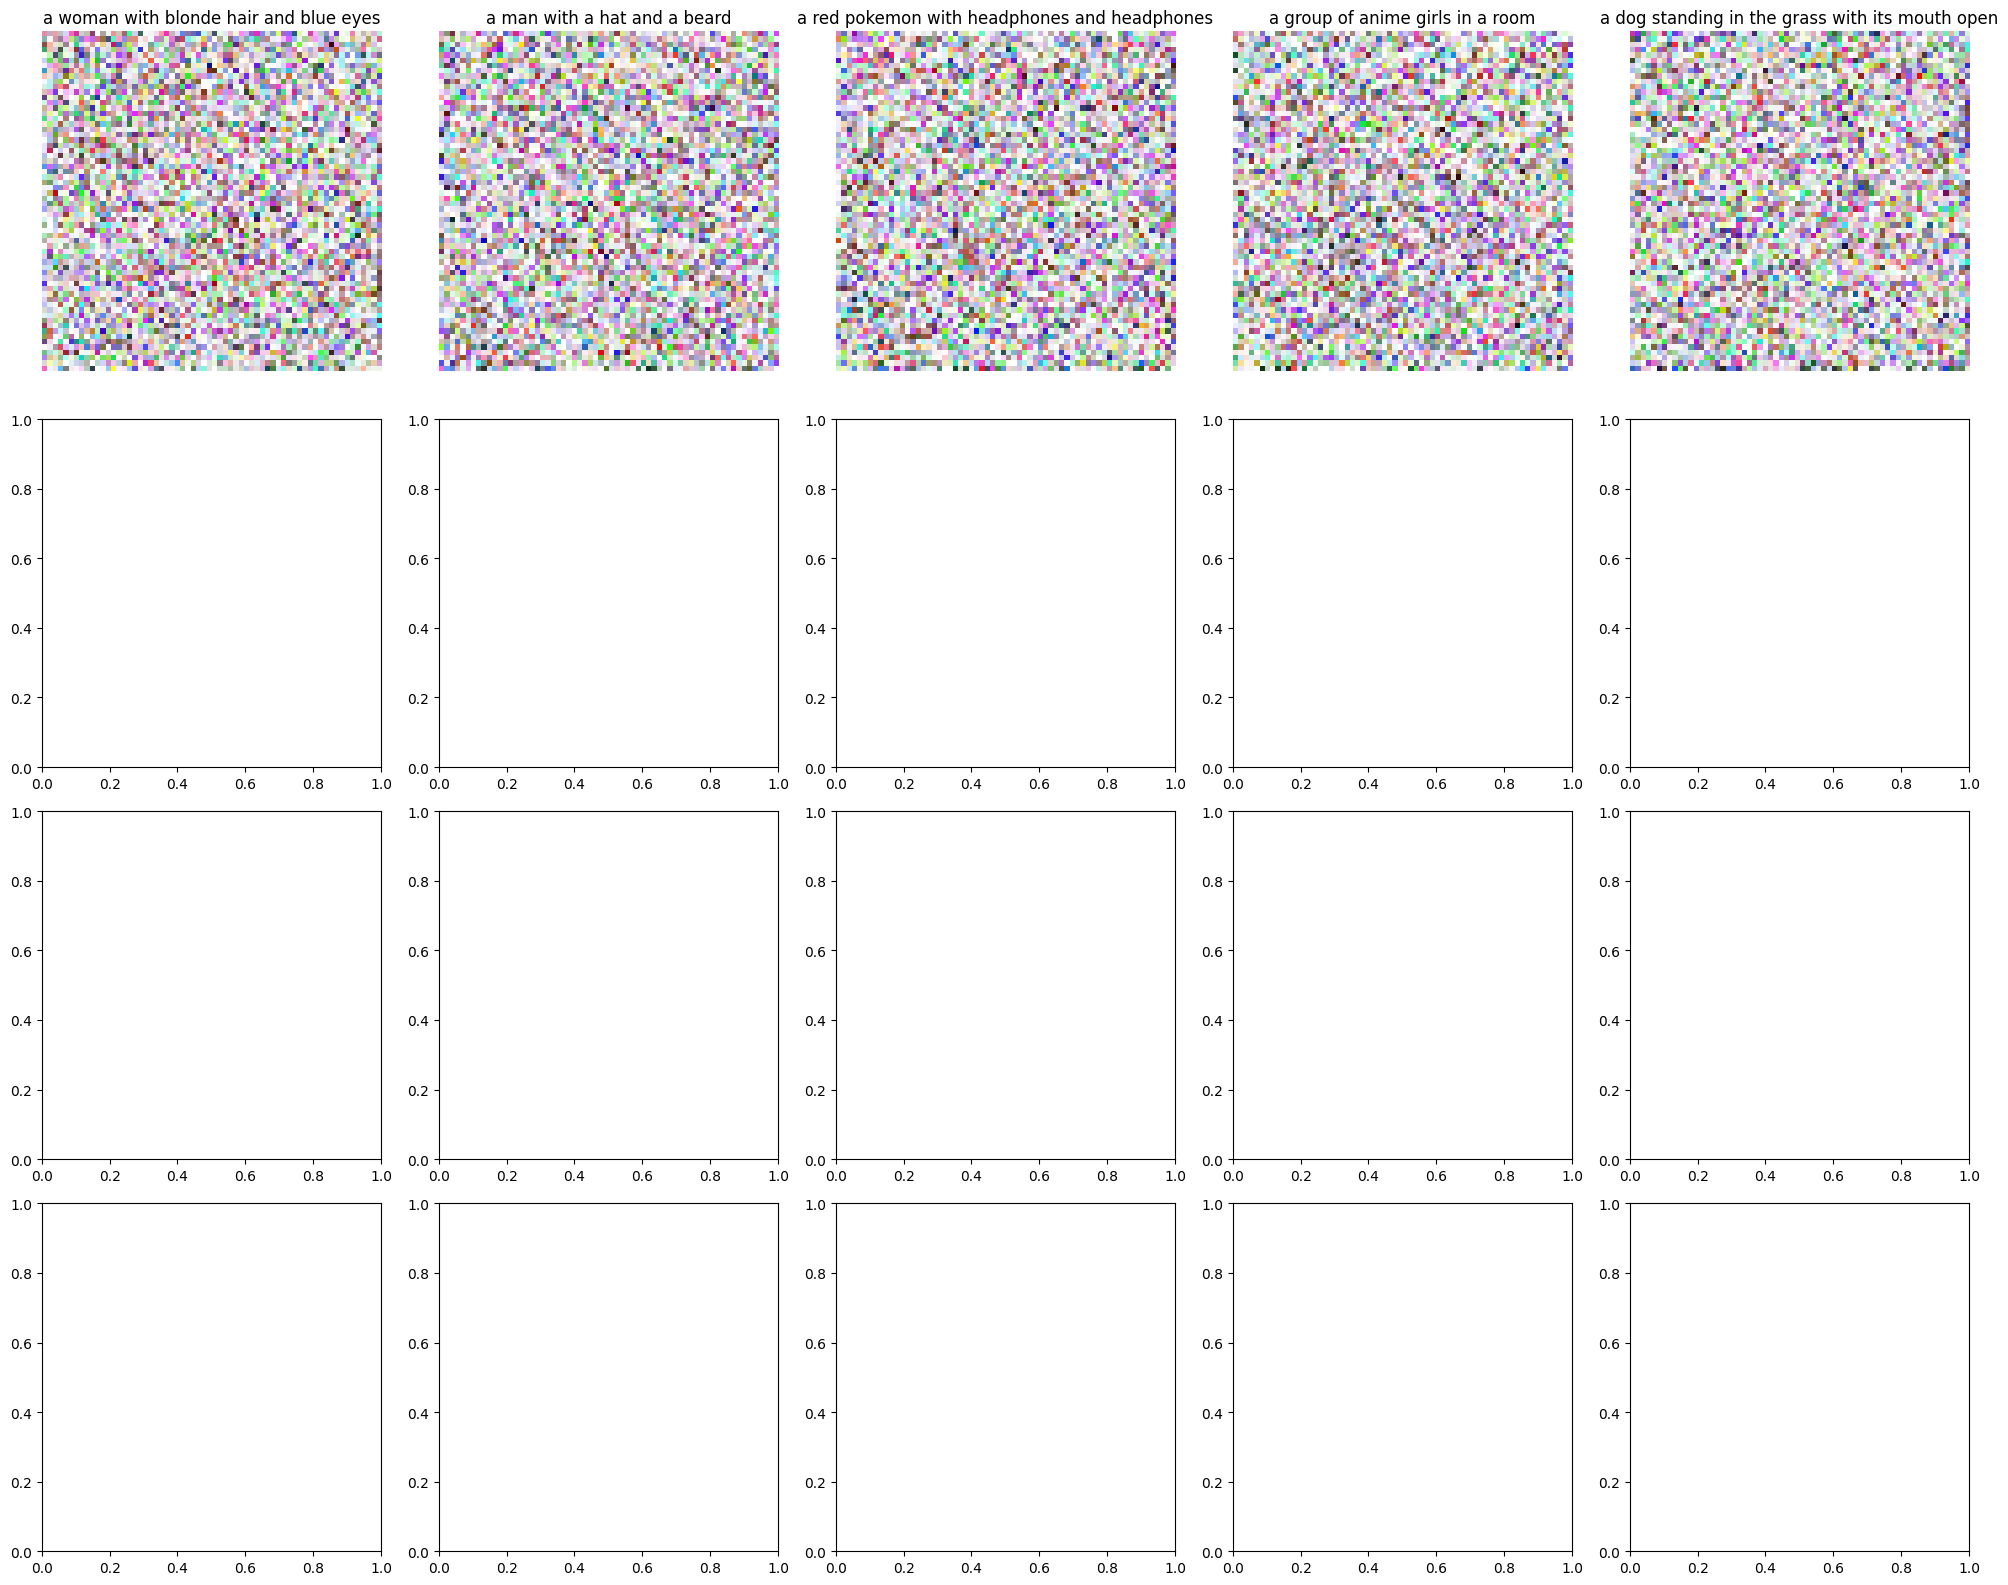

In [37]:
import matplotlib.pyplot as plt
import torch

def visualize_samples(unet, text_encoder, text_proj, dataset, num_samples=5, sampling_steps=150):
    unet.eval()
    fig, axs = plt.subplots(4, 5, figsize=(20, 16)) 
    for i in range(num_samples):
        batch = dataset[i]
        text = batch['text']
        input_ids = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=77)['input_ids'].to(device)

        encoder_hidden_states = text_encoder(input_ids).last_hidden_state
        encoder_hidden_states = text_proj(encoder_hidden_states)

        noise = torch.randn(1, 4, 64, 64).to(device)

        for step in range(sampling_steps):
            timestep = torch.tensor([sampling_steps - step - 1], device=device).long()
            with torch.no_grad():
                noise = unet(noise, timestep=timestep, encoder_hidden_states=encoder_hidden_states).sample

        sample = (noise.squeeze().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        axs[i // 5, i % 5].imshow(sample)
        axs[i // 5, i % 5].set_title(text)
        axs[i // 5, i % 5].axis("off")

    plt.tight_layout()
    plt.show()

for rank, model in results.items():
    print(f"Results for LoRA rank {rank}:")
    visualize_samples(model, text_encoder, text_proj, test_dataset_list, num_samples=5)


In [ ]:
import torch
import matplotlib.pyplot as plt
from transformers import CLIPTextModel, CLIPTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32').to(device)
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')

def generate_images_with_cfg(unet, text_encoder, text_proj, prompt, cfg_scales, sampling_steps=50):
    input_ids = tokenizer(prompt, return_tensors="pt", padding='max_length', truncation=True, max_length=77)['input_ids'].to(device)
    encoder_hidden_states = text_encoder(input_ids).last_hidden_state
    encoder_hidden_states = text_proj(encoder_hidden_states)
    
    fig, axs = plt.subplots(1, len(cfg_scales), figsize=(20, 5))
    for i, cfg_scale in enumerate(cfg_scales):
        
        noise = torch.randn(1, 4, 64, 64).to(device)
        for step in range(sampling_steps):
            timestep = torch.tensor([sampling_steps - step - 1], device=device).long()
            with torch.no_grad():
                noise = unet(noise, timestep=timestep, encoder_hidden_states=encoder_hidden_states, cfg_scale=cfg_scale).sample
        
        sample = (noise.squeeze().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        axs[i].imshow(sample)
        axs[i].set_title(f"CFG Scale: {cfg_scale}")
        axs[i].axis("off")
    
    plt.tight_layout()
    plt.show()


cfg_scales = [1, 5, 10, 15, 20]

for prompt in prompts:
    print(f"Results for prompt: {prompt}")
    generate_images_with_cfg(unet_with_lora, text_encoder, text_proj, prompt, cfg_scales)


Results for prompt: <special token> Naruto character


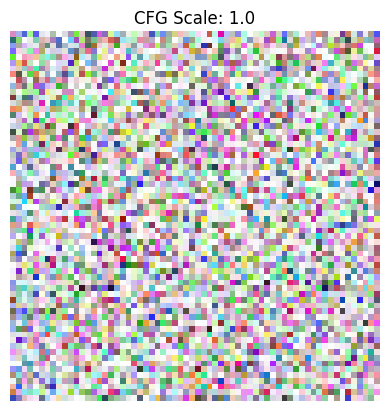

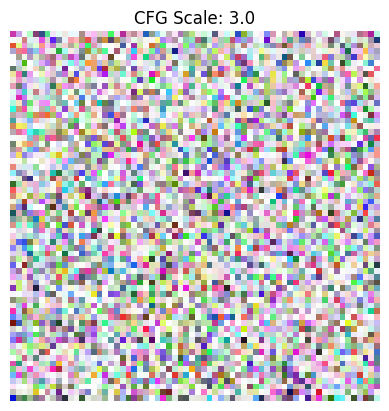

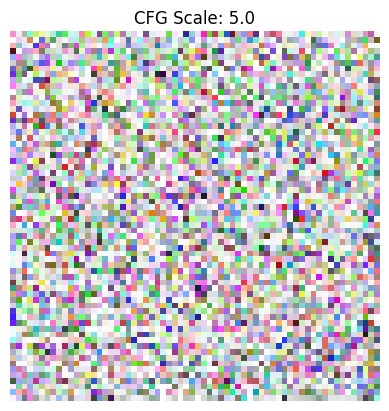

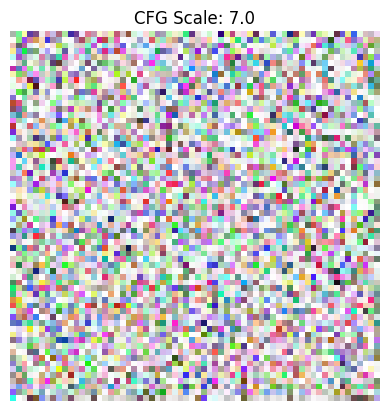

Results for prompt: <special token> Pikachu


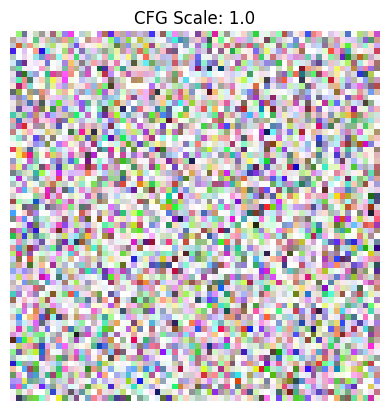

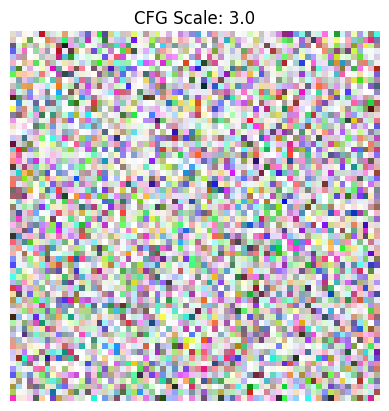

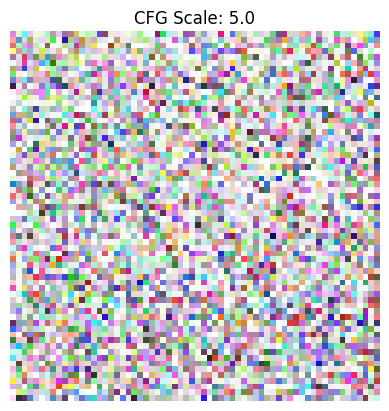

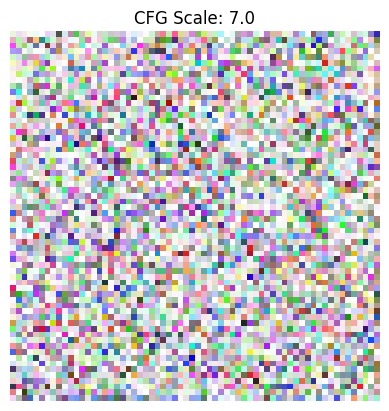

In [38]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

def generate_images_with_cfg(pipe, text_encoder, text_proj, prompt, cfg_scales, sampling_steps=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    input_ids = tokenizer(prompt, return_tensors="pt", padding='max_length', truncation=True, max_length=77)["input_ids"].to(device)

    with torch.no_grad():
        encoder_hidden_states = text_encoder(input_ids).last_hidden_state
        encoder_hidden_states = text_proj(encoder_hidden_states)

    unconditional_input_ids = tokenizer("", return_tensors="pt", padding='max_length', truncation=True, max_length=77)["input_ids"].to(device)
    with torch.no_grad():
        unconditional_encoder_hidden_states = text_encoder(unconditional_input_ids).last_hidden_state
        unconditional_encoder_hidden_states = text_proj(unconditional_encoder_hidden_states)

    for cfg_scale in cfg_scales:
        noise = torch.randn((1, 4, 64, 64)).to(device)
        for step in range(sampling_steps):
            timestep = torch.tensor([sampling_steps - step - 1], device=device).long()

            with torch.no_grad():
                conditional_output = unet(noise, timestep=timestep, encoder_hidden_states=encoder_hidden_states).sample

                unconditional_output = unet(noise, timestep=timestep, encoder_hidden_states=unconditional_encoder_hidden_states).sample

                noise = unconditional_output + cfg_scale * (conditional_output - unconditional_output)

        sample = (noise.squeeze().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        plt.imshow(sample)
        plt.title(f"CFG Scale: {cfg_scale}")
        plt.axis("off")
        plt.show()

prompts = ["Naruto character", "Pikachu"]

cfg_scales = [1.0, 3.0, 5.0, 7.0]
prompts = ["<special token> Naruto character", "<special token> Pikachu"]

for prompt in prompts:
    print(f"Results for prompt: {prompt}")
    generate_images_with_cfg(pipe, text_encoder, text_proj, prompt, cfg_scales)


In [ ]:
import os
import zipfile

zip_path = "/content/bowling_actions.zip"
unzip_dir = "/content/bowling_actions"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)


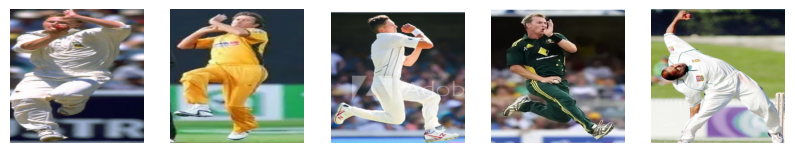

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_dir = "/kaggle/input/bowling-actions/bowling_actions"

image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.png', '.jpg', '.jpeg'))]

assert len(image_paths) >= 5, "You need at least 5 images for training"

def load_image(image_path, resolution=512):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((resolution, resolution))
    return image

images = [load_image(path) for path in image_paths]

plt.figure(figsize=(10, 10))
for i, img in enumerate(images[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()


In [2]:
import torch
from torch.utils.data import Dataset
from transformers import CLIPTokenizer, CLIPProcessor

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

class CustomTextualInversionDataset(Dataset):
    def __init__(self, image_paths, tokenizer, processor, resolution=512):
        self.image_paths = image_paths
        self.tokenizer = tokenizer
        self.processor = processor
        self.resolution = resolution

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = load_image(image_path, self.resolution)
        
        image = self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)
       
        text = "<special token>"
        text_ids = self.tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=77)["input_ids"].squeeze(0)
        return {"image": image, "text_ids": text_ids}


dataset = CustomTextualInversionDataset(image_paths, tokenizer, processor)


sample = dataset[0]
print(sample["image"].shape)
print(sample["text_ids"].shape)


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

2024-05-19 21:07:58.398685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 21:07:58.398816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 21:07:58.567522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

torch.Size([3, 224, 224])
torch.Size([77])


In [3]:
image_paths

['/kaggle/input/bowling-actions/bowling_actions/bowlingaction_lance_klusener.png',
 '/kaggle/input/bowling-actions/bowling_actions/bowlingaction_glenn_mcgrath.jpg.png',
 '/kaggle/input/bowling-actions/bowling_actions/bowlingaction_trent_boult.png',
 '/kaggle/input/bowling-actions/bowling_actions/bowlingaction_brettlee.jpg.png',
 '/kaggle/input/bowling-actions/bowling_actions/bowlingaction_paul_adams.png',
 '/kaggle/input/bowling-actions/bowling_actions/bowlingaction_shane_bond.png',
 '/kaggle/input/bowling-actions/bowling_actions/bowlingaction_zaheer_khan.png',
 '/kaggle/input/bowling-actions/bowling_actions/bowlingaction_mitchell_starc.png',
 '/kaggle/input/bowling-actions/bowling_actions/bowlingaction_james_anderson.png',
 '/kaggle/input/bowling-actions/bowling_actions/bowlingaction_dellstane.jpg',
 '/kaggle/input/bowling-actions/bowling_actions/bowlingaction_jasprit_bumra.png',
 '/kaggle/input/bowling-actions/bowling_actions/bowlingaction_muhammad_amir.jpg.png']

In [7]:
import os
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPTokenizer, CLIPProcessor, CLIPTextModel
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from tqdm import tqdm
from diffusers import StableDiffusionPipeline


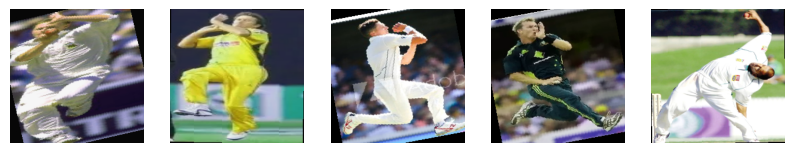

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Epoch 1/100: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Epoch 1, Loss: 0.5484


Epoch 2/100: 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]


Epoch 2, Loss: 0.3389


Epoch 3/100: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Epoch 3, Loss: 0.4180


Epoch 4/100: 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]


Epoch 4, Loss: 0.3244


Epoch 5/100: 100%|██████████| 3/3 [00:00<00:00,  6.99it/s]


Epoch 5, Loss: 0.2379


Epoch 6/100: 100%|██████████| 3/3 [00:00<00:00,  7.04it/s]


Epoch 6, Loss: 0.2040


Epoch 7/100: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]


Epoch 7, Loss: 0.1687


Epoch 8/100: 100%|██████████| 3/3 [00:00<00:00,  7.00it/s]


Epoch 8, Loss: 0.1650


Epoch 9/100: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]


Epoch 9, Loss: 0.1304


Epoch 10/100: 100%|██████████| 3/3 [00:00<00:00,  6.81it/s]


Epoch 10, Loss: 0.1188


Epoch 11/100: 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]


Epoch 11, Loss: 0.1050


Epoch 12/100: 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]


Epoch 12, Loss: 0.0932


Epoch 13/100: 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]


Epoch 13, Loss: 0.0903


Epoch 14/100: 100%|██████████| 3/3 [00:00<00:00,  6.80it/s]


Epoch 14, Loss: 0.0809


Epoch 15/100: 100%|██████████| 3/3 [00:00<00:00,  6.52it/s]


Epoch 15, Loss: 0.0746


Epoch 16/100: 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]


Epoch 16, Loss: 0.0718


Epoch 17/100: 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]


Epoch 17, Loss: 0.0684


Epoch 18/100: 100%|██████████| 3/3 [00:00<00:00,  6.91it/s]


Epoch 18, Loss: 0.0678


Epoch 19/100: 100%|██████████| 3/3 [00:00<00:00,  6.98it/s]


Epoch 19, Loss: 0.0677


Epoch 20/100: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s]


Epoch 20, Loss: 0.0654


Epoch 21/100: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s]


Epoch 21, Loss: 0.0644


Epoch 22/100: 100%|██████████| 3/3 [00:00<00:00,  7.00it/s]


Epoch 22, Loss: 0.0610


Epoch 23/100: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]


Epoch 23, Loss: 0.0678


Epoch 24/100: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


Epoch 24, Loss: 0.0657


Epoch 25/100: 100%|██████████| 3/3 [00:00<00:00,  6.99it/s]


Epoch 25, Loss: 0.0635


Epoch 26/100: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]


Epoch 26, Loss: 0.0671


Epoch 27/100: 100%|██████████| 3/3 [00:00<00:00,  6.67it/s]


Epoch 27, Loss: 0.0698


Epoch 28/100: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]


Epoch 28, Loss: 0.0729


Epoch 29/100: 100%|██████████| 3/3 [00:00<00:00,  6.95it/s]


Epoch 29, Loss: 0.0635


Epoch 30/100: 100%|██████████| 3/3 [00:00<00:00,  6.84it/s]


Epoch 30, Loss: 0.0664


Epoch 31/100: 100%|██████████| 3/3 [00:00<00:00,  6.77it/s]


Epoch 31, Loss: 0.0675


Epoch 32/100: 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]


Epoch 32, Loss: 0.0725


Epoch 33/100: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]


Epoch 33, Loss: 0.0767


Epoch 34/100: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s]


Epoch 34, Loss: 0.0755


Epoch 35/100: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


Epoch 35, Loss: 0.0763


Epoch 36/100: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s]


Epoch 36, Loss: 0.0642


Epoch 37/100: 100%|██████████| 3/3 [00:00<00:00,  6.91it/s]


Epoch 37, Loss: 0.0669


Epoch 38/100: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]


Epoch 38, Loss: 0.0679


Epoch 39/100: 100%|██████████| 3/3 [00:00<00:00,  6.87it/s]


Epoch 39, Loss: 0.0655


Epoch 40/100: 100%|██████████| 3/3 [00:00<00:00,  7.00it/s]


Epoch 40, Loss: 0.0639


Epoch 41/100: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]


Epoch 41, Loss: 0.0611


Epoch 42/100: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s]


Epoch 42, Loss: 0.0654


Epoch 43/100: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]


Epoch 43, Loss: 0.0602


Epoch 44/100: 100%|██████████| 3/3 [00:00<00:00,  6.99it/s]


Epoch 44, Loss: 0.0624


Epoch 45/100: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s]


Epoch 45, Loss: 0.0663


Epoch 46/100: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s]


Epoch 46, Loss: 0.0680


Epoch 47/100: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s]


Epoch 47, Loss: 0.0647


Epoch 48/100: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]


Epoch 48, Loss: 0.0726


Epoch 49/100: 100%|██████████| 3/3 [00:00<00:00,  6.68it/s]


Epoch 49, Loss: 0.0637


Epoch 50/100: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s]


Epoch 50, Loss: 0.0669


Epoch 51/100: 100%|██████████| 3/3 [00:00<00:00,  7.05it/s]


Epoch 51, Loss: 0.0630


Epoch 52/100: 100%|██████████| 3/3 [00:00<00:00,  7.01it/s]


Epoch 52, Loss: 0.0659


Epoch 53/100: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]


Epoch 53, Loss: 0.0632


Epoch 54/100: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


Epoch 54, Loss: 0.0618


Epoch 55/100: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s]


Epoch 55, Loss: 0.0704


Epoch 56/100: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]


Epoch 56, Loss: 0.0674


Epoch 57/100: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]


Epoch 57, Loss: 0.0631


Epoch 58/100: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


Epoch 58, Loss: 0.0656


Epoch 59/100: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s]


Epoch 59, Loss: 0.0663


Epoch 60/100: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


Epoch 60, Loss: 0.0617


Epoch 61/100: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s]


Epoch 61, Loss: 0.0701


Epoch 62/100: 100%|██████████| 3/3 [00:00<00:00,  7.13it/s]


Epoch 62, Loss: 0.0618


Epoch 63/100: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s]


Epoch 63, Loss: 0.0616


Epoch 64/100: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]


Epoch 64, Loss: 0.0613


Epoch 65/100: 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]


Epoch 65, Loss: 0.0619


Epoch 66/100: 100%|██████████| 3/3 [00:00<00:00,  6.68it/s]


Epoch 66, Loss: 0.0620


Epoch 67/100: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]


Epoch 67, Loss: 0.0639


Epoch 68/100: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s]


Epoch 68, Loss: 0.0593


Epoch 69/100: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]


Epoch 69, Loss: 0.0629


Epoch 70/100: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]


Epoch 70, Loss: 0.0640


Epoch 71/100: 100%|██████████| 3/3 [00:00<00:00,  6.98it/s]


Epoch 71, Loss: 0.0600


Epoch 72/100: 100%|██████████| 3/3 [00:00<00:00,  6.75it/s]


Epoch 72, Loss: 0.0643


Epoch 73/100: 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]


Epoch 73, Loss: 0.0623


Epoch 74/100: 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]


Epoch 74, Loss: 0.0658


Epoch 75/100: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]


Epoch 75, Loss: 0.0580


Epoch 76/100: 100%|██████████| 3/3 [00:00<00:00,  7.19it/s]


Epoch 76, Loss: 0.0644


Epoch 77/100: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]


Epoch 77, Loss: 0.0655


Epoch 78/100: 100%|██████████| 3/3 [00:00<00:00,  6.74it/s]


Epoch 78, Loss: 0.0620


Epoch 79/100: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]


Epoch 79, Loss: 0.0652


Epoch 80/100: 100%|██████████| 3/3 [00:00<00:00,  7.04it/s]


Epoch 80, Loss: 0.0617


Epoch 81/100: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]


Epoch 81, Loss: 0.0625


Epoch 82/100: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s]


Epoch 82, Loss: 0.0592


Epoch 83/100: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s]


Epoch 83, Loss: 0.0631


Epoch 84/100: 100%|██████████| 3/3 [00:00<00:00,  7.10it/s]


Epoch 84, Loss: 0.0632


Epoch 85/100: 100%|██████████| 3/3 [00:00<00:00,  7.05it/s]


Epoch 85, Loss: 0.0631


Epoch 86/100: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]


Epoch 86, Loss: 0.0600


Epoch 87/100: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s]


Epoch 87, Loss: 0.0636


Epoch 88/100: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


Epoch 88, Loss: 0.0641


Epoch 89/100: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]


Epoch 89, Loss: 0.0641


Epoch 90/100: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s]


Epoch 90, Loss: 0.0599


Epoch 91/100: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s]


Epoch 91, Loss: 0.0623


Epoch 92/100: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s]


Epoch 92, Loss: 0.0626


Epoch 93/100: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s]


Epoch 93, Loss: 0.0642


Epoch 94/100: 100%|██████████| 3/3 [00:00<00:00,  6.99it/s]


Epoch 94, Loss: 0.0597


Epoch 95/100: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]


Epoch 95, Loss: 0.0670


Epoch 96/100: 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]


Epoch 96, Loss: 0.0611


Epoch 97/100: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s]


Epoch 97, Loss: 0.0586


Epoch 98/100: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s]


Epoch 98, Loss: 0.0631


Epoch 99/100: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s]


Epoch 99, Loss: 0.0676


Epoch 100/100: 100%|██████████| 3/3 [00:00<00:00,  7.05it/s]


Epoch 100, Loss: 0.0628


In [8]:

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

from torchvision import transforms

augmentation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor()
])

class CustomTextualInversionDataset(Dataset):
    def __init__(self, image_paths, tokenizer, processor, resolution=224, augment=False):
        self.image_paths = image_paths
        self.tokenizer = tokenizer
        self.processor = processor
        self.resolution = resolution
        self.augment = augment
        self.transform = augmentation_transforms if augment else transforms.Compose([transforms.Resize((resolution, resolution)), transforms.ToTensor()])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = self.load_image(image_path)
        image = self.transform(image)
        text = "<special token>"
        text_ids = self.tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=77)["input_ids"].squeeze(0)
        return {"image": image, "text_ids": text_ids}

    def load_image(self, image_path):
        image = Image.open(image_path).convert("RGB")
        return image

dataset = CustomTextualInversionDataset(image_paths, tokenizer, processor, augment=True)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

images = [dataset[i]["image"].permute(1, 2, 0).numpy() for i in range(5)]
plt.figure(figsize=(10, 10))
for i, img in enumerate(images):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()

model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to("cuda")

text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")

class TextProjection(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TextProjection, self).__init__()
        self.proj = nn.Linear(input_dim, output_dim)

    def forward(self, hidden_states):
        return self.proj(hidden_states)

text_proj = TextProjection(512, 3 * 224 * 224).to("cuda")

def train_model(pipe, text_encoder, text_proj, dataloader, num_epochs=100, learning_rate=1e-4):
    text_encoder.train()
    text_proj.train()
    optimizer = optim.AdamW(list(text_encoder.parameters()) + list(text_proj.parameters()), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = batch["image"].to("cuda")
            text_ids = batch["text_ids"].to("cuda")

            optimizer.zero_grad()
            
            text_features = text_encoder(input_ids=text_ids).last_hidden_state
            text_features = text_features.mean(dim=1)
            text_features = text_proj(text_features)
            text_features = text_features.view(-1, 3, 224, 224)  

            loss = criterion(text_features, images)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader):.4f}")

    text_encoder.save_pretrained("textual_inversion_model")
    torch.save(text_proj.state_dict(), "textual_inversion_proj_model.pth")

train_model(pipe, text_encoder, text_proj, dataloader)



  0%|          | 0/50 [00:00<?, ?it/s]

odict_keys(['images', 'nsfw_content_detected'])


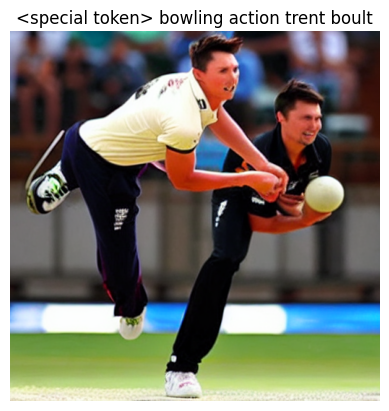

  0%|          | 0/50 [00:00<?, ?it/s]

odict_keys(['images', 'nsfw_content_detected'])


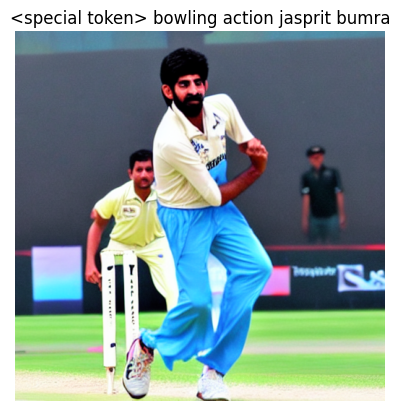

  0%|          | 0/50 [00:00<?, ?it/s]

odict_keys(['images', 'nsfw_content_detected'])


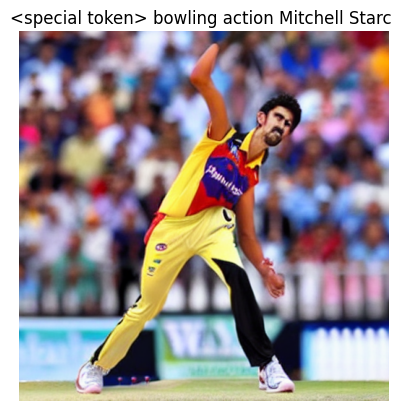

In [10]:
import matplotlib.pyplot as plt
from transformers import CLIPTextModel

prompts = ["<special token> bowling action trent boult", "<special token> bowling action jasprit bumra","<special token> bowling action Mitchell Starc "]

def visualize_results(pipe, prompts):
    for prompt in prompts:
        result = pipe(prompt)
        print(result.keys())
        image = result['images'][0]  
        plt.imshow(image)
        plt.title(prompt)
        plt.axis("off")
        plt.show()

visualize_results(pipe, prompts)
